## Imports

In [68]:
import os
import sys
import json
import pysam
import gcsfs
import tarfile
import upsetplot
import subprocess
import shutil

import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
import matplotlib.ticker as mticker
import matplotlib.font_manager as fm

from google.cloud import storage
from collections import Counter
from sklearn import metrics
from matplotlib import pyplot as plt
from matplotlib import cm
from tabulate import tabulate
from IPython.core.display import display, HTML
from pandas.api.types import CategoricalDtype

/tmp/ipykernel_72/1205821668.py:25: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [69]:
# ! pip install upsetplot

## Constants

In [70]:
use_cache = True

subset = "dragen_eval"
# subset = "gatksv_eval"
# subset = "gatksv_eval_0.1"

min_size_cache = None
max_size_cache = None
valid_types_cache = ["DEL", "DUP", "INS", "INV", "BND"]

min_size_filter = 5000
max_size_filter = None
valid_types_filter = ["DEL", "DUP"]

info_fields = ["SVTYPE", "AF", "STRAT", "TRUTH_VID"]

format_fields = ["GT", "GQ", "SL"]

In [71]:
in_dir = f"/home/jupyter/Files/inputs/concordance_cnv_per_sample"
out_dir = f"/home/jupyter/Files/outputs/concordance_cnv_per_sample"
os.makedirs(out_dir, exist_ok=True)

input_file_path = os.path.join(in_dir, f"{subset}.tar.gz")
output_file_path = os.path.join(out_dir, f"{subset}.tsv")
cached_df_path = os.path.join(out_dir, f"{subset}.cached.tsv")

palette = sns.set_palette("muted")

fm.fontManager.addfont("/home/jupyter/Files/inputs/Archive/arial.ttf")
fm.fontManager.addfont("/home/jupyter/Files/inputs/Archive/arialbd.ttf")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

support_color_map = {
    "Concordant": "#a9deb5",
    "Discordant": "#f7b2b2" 
}

chrom_order = {f'chr{i}': i for i in range(1, 23)}
chrom_order.update({'chrX': 23, 'chrY': 24})

## Helper Functions

In [72]:
_gt_non_ref_map = dict()

def _is_non_ref(gt):
    s = _gt_non_ref_map.get(gt, None)
    if s is None:
        s = any([a is not None and a > 0 for a in gt])
        _gt_non_ref_map[gt] = s
    return s

In [73]:
def compute_summary(df, n_samples, support_val=1, pre_filter=False, filter_col=None, filter_val=None, filter_col2=None, filter_val2=None):
    df_filtered = df[df[filter_col] == filter_val] if pre_filter else df
    if filter_col2 is not None and filter_val2 is not None:
        df_filtered = df_filtered[df_filtered[filter_col2] == filter_val2]
    
    calls_count = df_filtered.shape[0]
    calls_supported_count = df_filtered[df_filtered["STATUS"] >= support_val].shape[0]
    
    calls_per_genome = round(calls_count / n_samples, 2) if n_samples > 0 else 0
    call_supported_per_genome = round(calls_supported_count / n_samples, 2) if n_samples > 0 else 0
    calls_supported_proportion = f"{round((calls_supported_count / calls_count) * 100, 2)}%" if calls_count > 0 else 0
    
    filter_val = f"{filter_val} + {filter_val2}" if filter_col2 is not None and filter_val2 is not None else filter_val
    return [ filter_val, calls_per_genome, call_supported_per_genome, calls_supported_proportion ]

In [74]:
def plot_hist(data, x, bins=20, palette=palette, **kwargs):    
    g = sns.displot(
        data, x=x,
        multiple="stack",
        edgecolor=".3",
        linewidth=0.5,
        height=3, aspect=1.7,
        bins=bins,
        **kwargs
    )    
    
    if str(data[x].dtype) == "object" or isinstance(data[x].dtype, pd.CategoricalDtype):
        rotation = 90
        for ax in g.fig.axes:
            ax.set_xticks(range(len(data[x].cat.categories)))
            ax.set_xticklabels(data[x].cat.categories, rotation=rotation)

In [75]:
def plot_averaged_hist(data, group_col, n_samples, support_col="SUPPORT",
                         xtick_rotation=90,
                         xlabel=None, 
                         ylabel=None,
                         xticklabels=None,
                         legend_title=None,
                         legend_labels=None,
                         color_map=None,
                         legend_loc='best',
                         legend_bbox_to_anchor=None,
                         legend_frameon=True,
                         save_path=None,
                         group_order=None,
                         **kwargs):
    xlabel_fontsize = kwargs.pop('xlabel_fontsize', 12)
    ylabel_fontsize = kwargs.pop('ylabel_fontsize', 12)
    tick_fontsize = kwargs.pop('tick_fontsize', 11)
    total_fontsize = kwargs.pop('total_fontsize', 12)
    percent_fontsize = kwargs.pop('percent_fontsize', 12)
    legend_title_fontsize = kwargs.pop('legend_title_fontsize', 11)
    legend_fontsize = kwargs.pop('legend_fontsize', 10)
    
    df_plot = data.copy()

    if group_order:
        cat_type = CategoricalDtype(categories=group_order, ordered=True)
        df_plot[group_col] = df_plot[group_col].astype(cat_type)

    grouped = df_plot.groupby([group_col, support_col], observed=False).size().unstack(fill_value=0)
    grouped = grouped / n_samples

    ax = grouped.plot(kind="bar", stacked=True, color=color_map, legend=False, edgecolor="0", linewidth=0.3, **kwargs)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(ylabel if ylabel is not None else "Calls per Genome", fontsize=ylabel_fontsize, fontweight='bold')
    
    ax.set_xlabel(xlabel if xlabel is not None else group_col, fontsize=xlabel_fontsize, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    if xticklabels:
        ax.set_xticklabels(xticklabels, rotation=xtick_rotation)
    
    patches_by_bar = {}
    totals_per_group = grouped.sum(axis=1)
    for p in ax.patches:
        group_idx = int(np.round(p.get_x() + p.get_width() / 2))
        if group_idx not in patches_by_bar:
            patches_by_bar[group_idx] = []
        patches_by_bar[group_idx].append(p)

    for group_idx, patch_list in patches_by_bar.items():
        internal_patches = []
        external_patches = []
        placement_threshold = ax.get_ylim()[1] * 0.04

        for p in patch_list:
            if p.get_height() < placement_threshold:
                external_patches.append(p)
            else:
                internal_patches.append(p)

        for p in internal_patches:
            height = p.get_height()
            total = totals_per_group.iloc[group_idx]
            if height > 0 and total > 0:
                percent = height / total * 100
                if percent < 0.1: continue
                label = f"{percent:.2f}%"
                rgb = p.get_facecolor()[:3]
                luminance = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
                text_color = "white" if luminance < 0.4 else "black"
                ax.text(p.get_x() + p.get_width() / 2, p.get_y() + height / 2, label, 
                        ha="center", va="center", color=text_color, fontsize=percent_fontsize)

        if len(external_patches) > 0:
            if len(external_patches) > 1:
                target_patch = max(external_patches, key=lambda p: p.get_height())
                patches_to_label = [target_patch]
            else:
                patches_to_label = external_patches
            
            for p in patches_to_label:
                height = p.get_height()
                total = totals_per_group.iloc[group_idx]
                if height > 0 and total > 0:
                    percent = height / total * 100
                    if percent < 1: continue
                    label = f"{percent:.2f}%"
                    ax.text(p.get_x() + p.get_width() * 1.05, p.get_y() + height / 2, label, 
                            ha="left", va="center", color="black", fontsize=percent_fontsize)

    totals = grouped.sum(axis=1)
    ylim = ax.get_ylim()
    offset = (ylim[1] - ylim[0]) * 0.01
    xticks = ax.get_xticks()
    for i, total in enumerate(totals):
        ax.text(xticks[i], total + offset, f"{total:.2f}", ha="center", va="bottom", fontsize=total_fontsize)
    
    plt.tight_layout()
    
    handles, labels = ax.get_legend_handles_labels()
    if legend_labels:
        labels = legend_labels
    
    ax.legend(
        handles,
        labels,
        title=legend_title,
        loc=legend_loc,
        bbox_to_anchor=legend_bbox_to_anchor,
        fontsize=legend_fontsize,
        title_fontsize=legend_title_fontsize,
        frameon=legend_frameon
    )
    
    if save_path:
        plt.savefig(save_path, transparent=True, dpi=300, bbox_inches='tight')
    
    plt.show()

## Process

### Verification

In [76]:
if not use_cache and os.path.exists(cached_df_path):
    raise Exception("Cached file already exists at given location - are you sure you wish to proceed?")

In [77]:
if use_cache and not os.path.exists(cached_df_path):
    raise Exception("Cached file does not exist at given location - please set use_cache to False.")

### File Generation

In [78]:
# Load per-caller VCFs

if not use_cache:
    gcs_client = storage.Client()
    
    with open(output_file_path, "w") as tsv:
        tsv.write("\t".join(["VID", "SAMPLE", "CHROM", "POS", "SVTYPE", "SVLEN", "FILTER", "STATUS"] + info_fields + format_fields)+ "\n")

    with tarfile.open(input_file_path, "r:gz") as tar:
        tar.extractall(path=out_dir)

    vcf_file_paths = []
    for root, dirs, files in os.walk(out_dir):
        for file in files:
            if file.endswith(".vcf.gz"):
                full_path = os.path.join(root, file)
                vcf_file_paths.append(full_path)


    for file_path in vcf_file_paths:
        with pysam.VariantFile(file_path) as vcf, open(output_file_path, "a") as tsv:
            for r in vcf:
                svtype = r.info.get("SVTYPE", None)
                svlen = r.info.get("SVLEN", None) if r.info.get("SVLEN", None) else (r.stop - r.pos)


                if valid_types_cache is not None:
                    if svtype not in valid_types_cache:
                        continue

                if max_size_cache is not None:
                    if svlen > max_size_cache:
                        continue

                if min_size_cache is not None:
                    if svlen < min_size_cache:
                        continue

                sample_id = vcf.header.samples[0]
                filters = ",".join(f for f in r.filter)
                infs = [r.info.get(k, None) for k in info_fields]
                fmts = [r.samples[sample_id].get(k, None) for k in format_fields if k in format_fields]

                row_data = [
                    r.id,
                    sample_id,
                    r.chrom,
                    r.pos,
                    svtype,
                    svlen,
                    filters,
                    1 if r.info.get("STATUS", "") == "TP" else 0
                ] + infs + fmts

                tsv.write("\t".join(str(x) for x in row_data) + "\n")
                
    shutil.rmtree(os.path.join(out_dir, "mnt"))

### Dataframe Processing

In [79]:
# Formatting

if not use_cache:
    df = pd.read_csv(output_file_path, sep="\t")

    # Set column types
    df = df.astype({"SVLEN": int, "SVTYPE": str})
    if "GQ" in df.columns:
        df["GQ"] = df["GQ"].astype(float)
    if "SL" in df.columns:
        df["SL"] = df["SL"].astype(float)
        
    # Process AF
    if "AF" in df.columns:
        df["AF"] = df["AF"].astype(str).str.replace(r"[(),]", "", regex=True).astype(float)

    # Process STRAT
    if "STRAT" in df.columns:
        def assign_strat(s):
            if pd.isna(s):
                return "Unique"
            elif "SR_" in s:
                return "SR"
            elif "SD_" in s:
                return "SD"
            elif "RM_" in s:
                return "RM"
            else:
                return "Unique"

        df["STRAT"] = df["STRAT"].apply(assign_strat)
                
    # Process categorical
    df['SVTYPE'] = pd.Categorical(df['SVTYPE'])
    
    df['STRAT'] = pd.Categorical(df['STRAT'])

In [80]:
if not use_cache:
    df.to_csv(cached_df_path, sep="\t", index=False)

## Load

In [81]:
df = pd.read_csv(cached_df_path, sep="\t")

df.head()

,VID,SAMPLE,CHROM,POS,SVTYPE,SVLEN,FILTER,STATUS,SVTYPE.1,AF,STRAT,TRUTH_VID,GT,GQ,SL
0,DRAGEN_LOSS_chr1_1447061_1496366,RGP_1238_3,chr1,1447060,DEL,49307,NaN,0,DEL,0.019149,SD,NaN,"(0, 1)",NaN,NaN
1,DRAGEN_LOSS_chr1_2650428_2651463,RGP_1238_3,chr1,2650427,DEL,1037,NaN,0,DEL,0.740426,SR,NaN,"(1, 1)",NaN,NaN
2,DRAGEN_GAIN_chr1_13224580_13242034,RGP_1238_3,chr1,13224579,DUP,17456,NaN,0,DUP,0.825532,SD,NaN,"(1, 1)",NaN,NaN
3,DRAGEN_LOSS_chr1_14109580_14112782,RGP_1238_3,chr1,14109579,DEL,3204,NaN,0,DEL,0.087234,Unique,NaN,"(0, 1)",NaN,NaN
4,DRAGEN_GAIN_chr1_16605062_16646293,RGP_1238_3,chr1,16605061,DUP,41233,NaN,0,DUP,0.774468,SD,NaN,"(1, 1)",NaN,NaN


In [82]:
# Formatting

df['SVTYPE'] = pd.Categorical(df['SVTYPE'])

df['STRAT'] = pd.Categorical(df['STRAT'])

df["SUPPORT"] = "Discordant"
df.loc[df["STATUS"] == 1, "SUPPORT"] = "Concordant"
df['SUPPORT'] = pd.Categorical(df['SUPPORT'])

conditions = [
    df["AF"] < 0.01,
    df["AF"] <= 0.05,
    df["AF"] > 0.05
]
choices = [
    "AF < 1%",
    "AF 1-5%",
    "AF > 5%"
]
df["AF_BUCKET"] = np.select(conditions, choices)
df["AF_BUCKET"] = pd.Categorical(
    df["AF_BUCKET"],
    categories=["AF < 1%", "AF 1-5%", "AF > 5%"],
    ordered=True
)

conditions = [
    df["SVLEN"] < 50000,
    df["SVLEN"] <= 100000,
    df["SVLEN"] > 100000
]
choices = [
    "SVLEN < 50 kbp",
    "SVLEN 50-100 kbp",
    "SVLEN > 100 kbp"
]
df["SVLEN_BUCKET"] = np.select(conditions, choices)
df["SVLEN_BUCKET"] = pd.Categorical(
    df["SVLEN_BUCKET"],
    categories=["SVLEN < 50 kbp", "SVLEN 50-100 kbp", "SVLEN > 100 kbp"],
    ordered=True
)
df["log_SVLEN"] = np.log10(df["SVLEN"].where(df["SVLEN"] > 0, np.nan))

n_samples = df['SAMPLE'].nunique()
print(f"Total Unique Samples: {n_samples}\n")

Total Unique Samples: 235



In [83]:
# Filtering
  
# Remove SVLEN > max_size
if max_size_filter is not None:
    bef = len(df)
    df = df[df["SVLEN"] <= max_size_filter]
    print(f"[SVLEN > Max Size] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove SVLEN < min_size
if min_size_filter is not None:
    bef = len(df)
    df = df[df["SVLEN"] >= min_size_filter]
    print(f"[SVLEN < Min Size] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove invalid SVTYPE
if valid_types_filter is not None:
    bef = len(df)
    df = df[df["SVTYPE"].isin(valid_types_filter)]
    print(f"[Invalid SVTYPE] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")
    
# Explicitly remove CNVs
bef = len(df)
df = df[~df['VID'].str.contains('CNV')]
print(f"[CNVs] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

# Remove non-PASS FILTER
bef = len(df)
df = df[df["FILTER"].isna() | (df["FILTER"] == "PASS")]
print(f"[PASS Only] Dropped {bef - len(df)} records ({round((bef - len(df)) * 100 / bef, 2)}%), now left with {len(df)}.\n")

df.head()

[SVLEN < Min Size] Dropped 103907 records (62.93%), now left with 61203.

[Invalid SVTYPE] Dropped 0 records (0.0%), now left with 61203.

[CNVs] Dropped 0 records (0.0%), now left with 61203.

[PASS Only] Dropped 0 records (0.0%), now left with 61203.



,VID,SAMPLE,CHROM,POS,SVTYPE,SVLEN,FILTER,STATUS,SVTYPE.1,AF,STRAT,TRUTH_VID,GT,GQ,SL,SUPPORT,AF_BUCKET,SVLEN_BUCKET,log_SVLEN
0,DRAGEN_LOSS_chr1_1447061_1496366,RGP_1238_3,chr1,1447060,DEL,49307,NaN,0,DEL,0.019149,SD,NaN,"(0, 1)",NaN,NaN,Discordant,AF 1-5%,SVLEN < 50 kbp,4.692909
2,DRAGEN_GAIN_chr1_13224580_13242034,RGP_1238_3,chr1,13224579,DUP,17456,NaN,0,DUP,0.825532,SD,NaN,"(1, 1)",NaN,NaN,Discordant,AF > 5%,SVLEN < 50 kbp,4.241945
4,DRAGEN_GAIN_chr1_16605062_16646293,RGP_1238_3,chr1,16605061,DUP,41233,NaN,0,DUP,0.774468,SD,NaN,"(1, 1)",NaN,NaN,Discordant,AF > 5%,SVLEN < 50 kbp,4.615245
5,DRAGEN_GAIN_chr1_16716712_16728256,RGP_1238_3,chr1,16716711,DUP,11546,NaN,0,DUP,0.740426,SD,NaN,"(1, 1)",NaN,NaN,Discordant,AF > 5%,SVLEN < 50 kbp,4.062432
6,DRAGEN_GAIN_chr1_16879752_16950196,RGP_1238_3,chr1,16879751,DUP,70446,NaN,1,DUP,0.604255,SD,all_sample_sets.chr1.final_cleanup_DUP_chr1_79,"(1, 1)",NaN,NaN,Concordant,AF > 5%,SVLEN 50-100 kbp,4.847856


## Analyze

### Results for SVLEN > 5KB

In [84]:
display(HTML("<style>.container { width:100% !important; }</style>"))

total_calls = df.shape[0]
print(f"Total Calls: {total_calls}")

table_headers = [ "Calls/Genome", "Calls Supported/Genome", "% Calls Supported" ]

print("\nLR Caller Support >= i")
table_rows = []
for i in range(0, 2):
    table_rows.append(compute_summary(df, n_samples, support_val=i, filter_val=i))
print(tabulate(table_rows, headers=[">= i"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

print("\nLR Caller Support by SVTYPE")
table_rows = []
for svtype in df["SVTYPE"].dropna().unique():
    table_rows.append(compute_summary(df, n_samples, pre_filter=True, filter_col="SVTYPE", filter_val=svtype))
print(tabulate(table_rows, headers=["SVTYPE"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

print("\nLR Caller Support by STRAT")
table_rows = []
for strat in sorted(df["STRAT"].dropna().unique(), key=lambda x: (len(x), x)):
    table_rows.append(compute_summary(df, n_samples, pre_filter=True, filter_col="STRAT", filter_val=strat))
print(tabulate(table_rows, headers=["STRAT"] + table_headers, tablefmt="fancy_grid", colalign=("center",)*4))

Total Calls: 61203

LR Caller Support >= i
╒════════╤════════════════╤══════════════════════════╤═════════════════════╕
│  >= i  │  Calls/Genome  │  Calls Supported/Genome  │  % Calls Supported  │
╞════════╪════════════════╪══════════════════════════╪═════════════════════╡
│   0    │     260.44     │          260.44          │       100.0%        │
├────────┼────────────────┼──────────────────────────┼─────────────────────┤
│   1    │     260.44     │          140.85          │       54.08%        │
╘════════╧════════════════╧══════════════════════════╧═════════════════════╛

LR Caller Support by SVTYPE
╒══════════╤════════════════╤══════════════════════════╤═════════════════════╕
│  SVTYPE  │  Calls/Genome  │  Calls Supported/Genome  │  % Calls Supported  │
╞══════════╪════════════════╪══════════════════════════╪═════════════════════╡
│   DEL    │     182.39     │          120.57          │        66.1%        │
├──────────┼────────────────┼──────────────────────────┼─────────────────

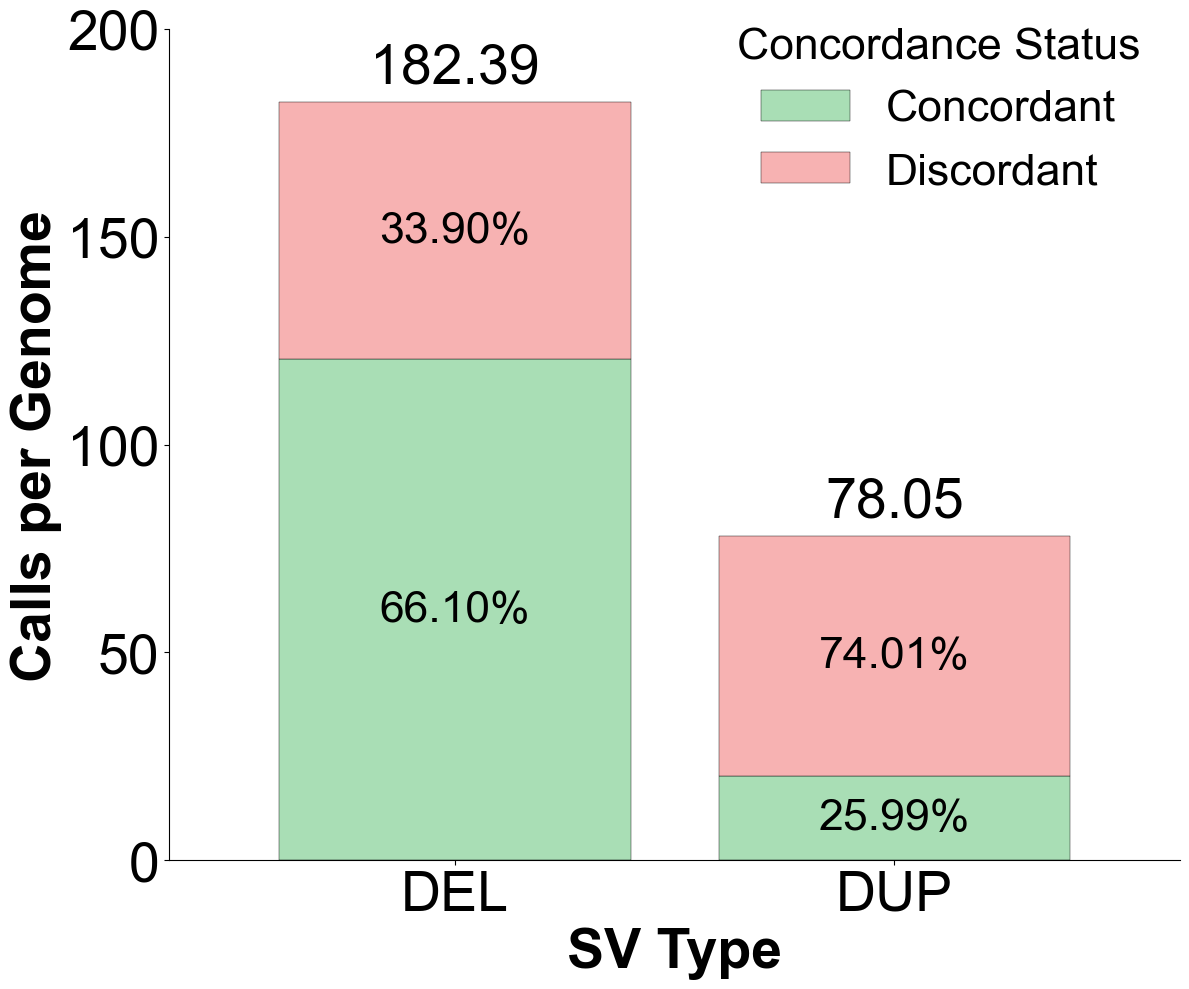

In [85]:
plot_averaged_hist(df, group_col="SVTYPE", n_samples=n_samples, support_col="SUPPORT", group_order=["DEL", "DUP"],
                   color_map=support_color_map, save_path=os.path.join(out_dir, f"{subset}_SVTYPE_averaged_hist.png"),
                   xlabel='SV Type', xticklabels=['DEL', 'DUP'],
                   legend_title='Concordance Status', legend_labels=['Concordant', 'Discordant'],
                   legend_loc='upper right', legend_bbox_to_anchor=(1, 1.05), legend_frameon=False,
                   xlabel_fontsize=40, ylabel_fontsize=40,
                   tick_fontsize=40, total_fontsize=40, percent_fontsize=32,
                   legend_title_fontsize=32, legend_fontsize=32,
                   ylim=(0, 200), figsize=(12, 10), width=0.8, xtick_rotation=0)

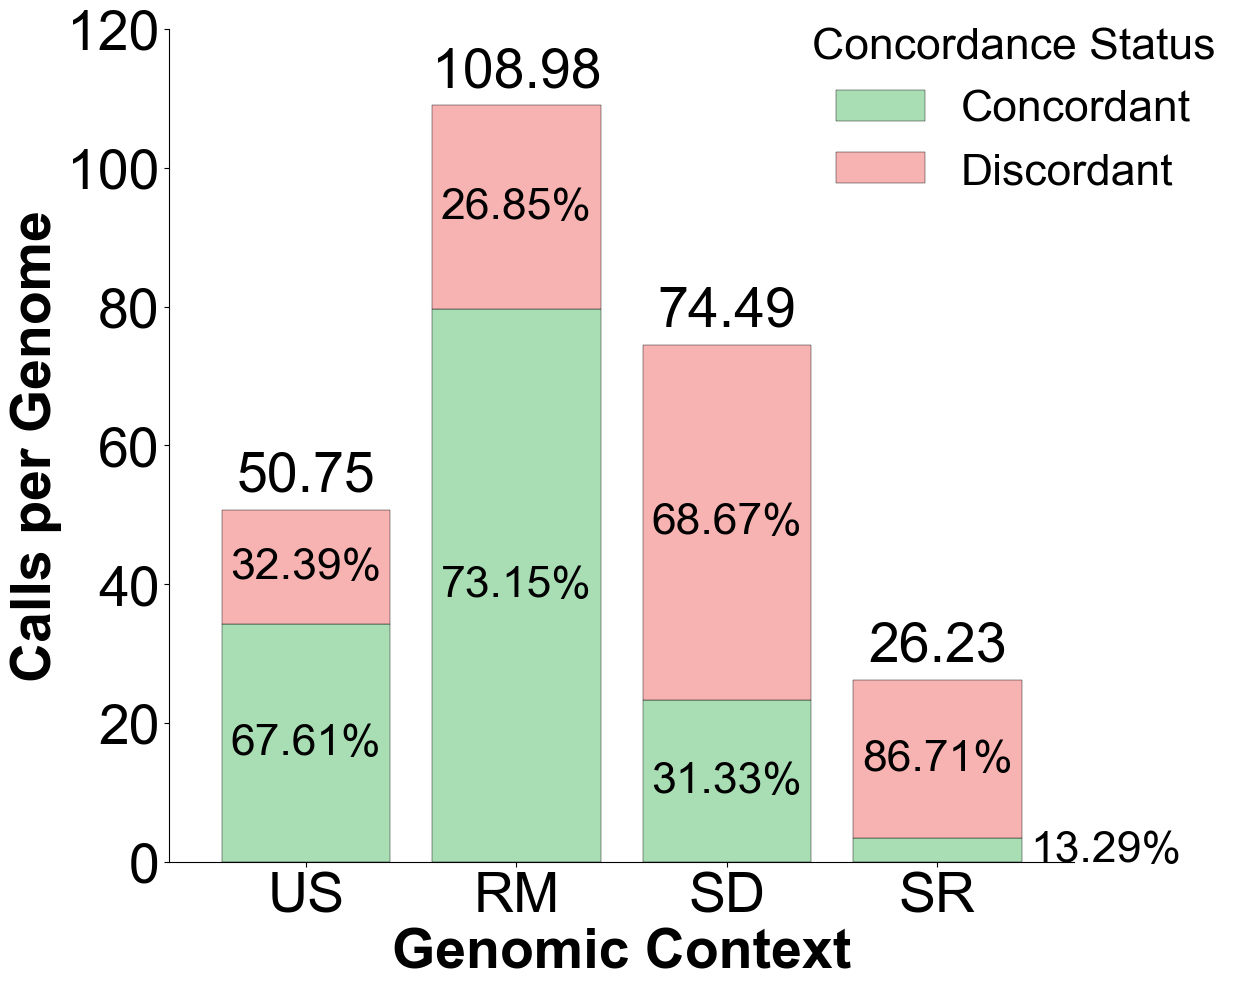

In [86]:
plot_averaged_hist(df, group_col="STRAT", n_samples=n_samples, support_col="SUPPORT", group_order=["Unique", "RM", "SD", "SR"],
                   color_map=support_color_map, save_path=os.path.join(out_dir, f"{subset}_STRAT_averaged_hist.png"),
                   xlabel='Genomic Context', xticklabels=['US', 'RM', 'SD', 'SR'],
                   legend_title='Concordance Status', legend_labels=['Concordant', 'Discordant'],
                   legend_loc='upper right', legend_bbox_to_anchor=(1.2, 1.05), legend_frameon=False,
                   xlabel_fontsize=40, ylabel_fontsize=40,
                   tick_fontsize=40, total_fontsize=40, percent_fontsize=32,
                   legend_title_fontsize=32, legend_fontsize=32,
                   ylim=(0, 120), figsize=(12, 10), width=0.8, xtick_rotation=0)

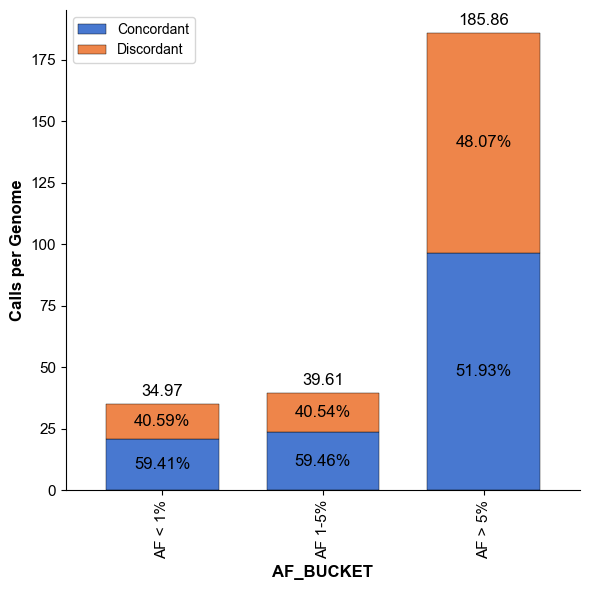

In [87]:
plot_averaged_hist(df, n_samples=n_samples, group_col="AF_BUCKET", support_col="SUPPORT", figsize=(6, 6), width=0.7)

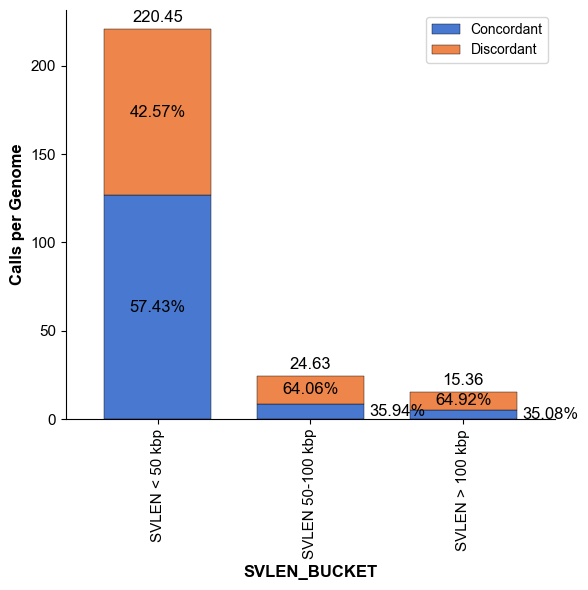

In [88]:
plot_averaged_hist(df, n_samples=n_samples, group_col="SVLEN_BUCKET", support_col="SUPPORT", figsize=(6, 6), width=0.7)

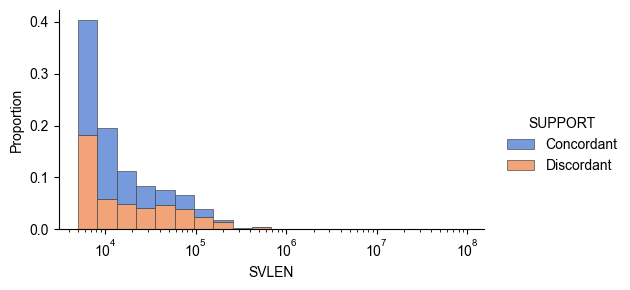

In [89]:
plot_hist(df, "SVLEN", hue="SUPPORT", stat="proportion", log_scale=(True, False))

### Manual Review

In [90]:
if subset == "dragen_eval":
    min_size_threshold = 10000
else:
    min_size_threshold = 5000

In [91]:
df_uniq = df[(df['STRAT'] == 'Unique') & (df['SVTYPE'] == 'DEL')]
for svlen_range in [(min_size_threshold,50000), (50000, float('inf'))]:
    for af_range in [(float('-inf'), 0.01), (0.01, float('inf'))]:
        count_tp = len(df_uniq[(df_uniq['SVLEN'] >= svlen_range[0]) & (df_uniq['SVLEN'] < svlen_range[1]) & (df_uniq['AF'] >= af_range[0]) & (df_uniq['AF'] < af_range[1]) & (df_uniq['STATUS'] == 1)])
        print(f"{svlen_range} + {af_range}: {count_tp}")

(10000, 50000) + (-inf, 0.01): 440
(10000, 50000) + (0.01, inf): 1218
(50000, inf) + (-inf, 0.01): 67
(50000, inf) + (0.01, inf): 42


In [92]:
df_uniq = df[(df['STRAT'] == 'Unique') & (df['SVTYPE'] == 'DUP')]
for svlen_range in [(min_size_threshold,50000), (50000, float('inf'))]:
    for af_range in [(float('-inf'), 0.01), (0.01, float('inf'))]:
        count_tp = len(df_uniq[(df_uniq['SVLEN'] >= svlen_range[0]) & (df_uniq['SVLEN'] < svlen_range[1]) & (df_uniq['AF'] >= af_range[0]) & (df_uniq['AF'] < af_range[1]) & (df_uniq['STATUS'] == 1)])
        print(f"{svlen_range} + {af_range}: {count_tp}")

(10000, 50000) + (-inf, 0.01): 183
(10000, 50000) + (0.01, inf): 407
(50000, inf) + (-inf, 0.01): 103
(50000, inf) + (0.01, inf): 253


In [93]:
df_filtered = df[(df['STATUS'] == 0) & (df['SVLEN'] > min_size_threshold) & (df['STRAT'] == 'Unique')].copy()
df_filtered['CHROM_SORT'] = df_filtered['CHROM'].map(chrom_order)

df_filtered = df_filtered.sort_values(['CHROM_SORT', 'POS'])
df_filtered = df_filtered[['VID', 'SAMPLE', 'CHROM', 'POS', 'STRAT', 'SVTYPE', 'SVLEN', 'SVLEN_BUCKET', 'AF', 'AF_BUCKET', 'STATUS']]
df_filtered.to_csv(os.path.join(out_dir, f"{subset}_manual_evaluation.tsv"), header=None, sep="\t", index=False)

print(len(df_filtered))

1724
